# Hypersolver training with different architectures

Here we perform the training with different architectures. In particular, we consider Multi-layers Perceptrons with different activations:
1. Tanh
2. ReLU
3. Snake
And also the architecture of
4. SIREN

And save the results for an analysis on generalization

In [63]:
import torch 
import torch.nn as nn 
from warnings import warn
import matplotlib.pyplot as plt
import sys; sys.path.append(2*'../')
from src import *

device = torch.device('cuda:1' if(torch.cuda.is_available()) else 'cpu')
print('Device:', device)

Device: cuda:1


In [64]:
device = 'cpu' # override

In [65]:
# Reinitialize
bs = 1000

U = RandConstController([bs, 1], -3, 3)
system = ControlledPendulum(U)

## Residuals computation

In [66]:
from torchdiffeq import odeint as odeint

def compute_residual(system, t, Δt, x, u, hs, model='SIREN', method='dopri5' ):
    """
    x: u_batch, batch, dimr
    u: u_batch, batch, dim
    """
    t_span = torch.tensor([t, t + Δt]).to(x)
    system.u.u0 = u
    f = system._dynamics(t, x)

    if x.shape == u.shape or u.shape[1] == 16:  # plots
        xfu = torch.cat([x, f, u], -1)
    else:
        xfu = torch.cat([x, f, u.repeat(1, x.shape[1], 1)], -1)
    
    xfu = torch.cat([x, f, u], -1)
    if model == 'SIREN':
        g, _ = hs(xfu) # unpack for SIREN coord (unused)
    elif model == 'euler':
        g = 0
    else:
        g = hs(xfu)
    zd = odeint(system._dynamics, x, t_span, method=method)[-1]
    z  = system(x, t_span).squeeze(0)[-1]
  
    R = (zd - z)/(Δt**2)
    L = torch.norm(R - g, dim=-1, p=2)
    return L                  

In [67]:
# Common settings

from math import pi
x_min_train, x_max_train = -2*pi, 2*pi
x_min_plot, x_max_plot = -15, 15 # we plot unexplored regions
t = 0
Δt = 0.1
n_grid = 100 ; u_b = 10
u_grid = torch.linspace(-u_b, u_b, n_grid).unsqueeze(1)


EPOCHS = 200000
lr = 1e-4

## Training the system with `SIREN-HyperEuler`

In [68]:
hs_siren = Siren(in_features=5, out_features=2, hidden_features=64, hidden_layers=2, outermost_linear=True)

pytorch_total_params = sum(p.numel() for p in hs_siren.parameters())
print(pytorch_total_params)
# for name, param in hs.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

8834


## Training loop SIREN-HyperEuler

In [69]:
from tqdm import trange

opt = torch.optim.Adam(hs_siren.parameters(), lr=lr)

losses = []

bs = 1000
count = 0

with trange(0, EPOCHS, desc="Epochs") as epochs:
    for epoch in epochs:
        opt.zero_grad()
        
        x = torch.Tensor(bs, 2).uniform_(x_min_train, x_max_train)
        
        # Choose random indices",
        index = torch.randint(u_grid.shape[0], (bs,))
        u_rand = u_grid[index]

        # compute again residual for hypersolver training
        loss = compute_residual(system, t, Δt, x[:, None, :], u_rand[:, None, :], hs_siren).mean()

        # optimization step
        loss.backward()
        opt.step()
        
        losses.append(loss.detach().cpu())
        # print(f"e:{epoch}, loss:%.3f" % loss, end="\r")
        epochs.set_postfix(loss=(loss.detach().cpu().item()))


Epochs: 100%|██████████| 200000/200000 [27:47<00:00, 119.93it/s, loss=3.78]


In [70]:
torch.save(hs_siren, 'saved_models/hs_siren.pt')

Text(0.5, 1.0, 'Hypersolver loss')

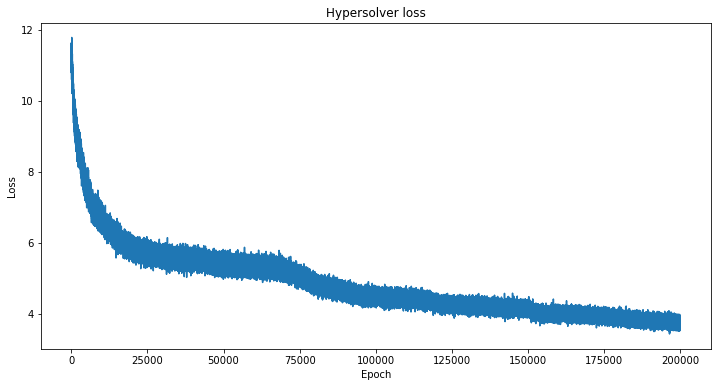

In [71]:
import numpy as np

dummmy = np.linspace(0,EPOCHS,EPOCHS)
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.plot( np.asarray(losses))
ax.set_title('Hypersolver loss')

## Snake

In [72]:
class SnakeHyperSolver(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=32):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)

        # Initialize activations
        self.a1 = Snake(hidden_dim)
        self.a2 = Snake(hidden_dim)

    
    def forward(self, x):
        x = self.a1(self.fc1(x))
        x = self.a2(self.fc2(x))
        x = self.fc3(x)
        return x

hs_snake = SnakeHyperSolver(5, 2, hidden_dim=64)

pytorch_total_params = sum(p.numel() for p in hs_snake.parameters())
print(pytorch_total_params)

4802


In [73]:
opt = torch.optim.Adam(hs_snake.parameters(), lr=lr)

losses = []

bs = 1000
count = 0

with trange(0, EPOCHS, desc="Epochs") as epochs:
    for epoch in epochs:
        opt.zero_grad()
        
        x = torch.Tensor(bs, 2).uniform_(x_min_train, x_max_train)
        
        # Choose random indices",
        index = torch.randint(u_grid.shape[0], (bs,))
        u_rand = u_grid[index]

        # compute again residual for hypersolver training
        loss = compute_residual(system, t, Δt, x[:, None, :], u_rand[:, None, :], hs_snake, model='snake').mean()

        # optimization step
        loss.backward()
        opt.step()
        
        losses.append(loss.detach().cpu())
        # print(f"e:{epoch}, loss:%.3f" % loss, end="\r")
        epochs.set_postfix(loss=(loss.detach().cpu().item()))

Epochs: 100%|██████████| 200000/200000 [28:17<00:00, 117.85it/s, loss=0.135]


Text(0.5, 1.0, 'Hypersolver loss')

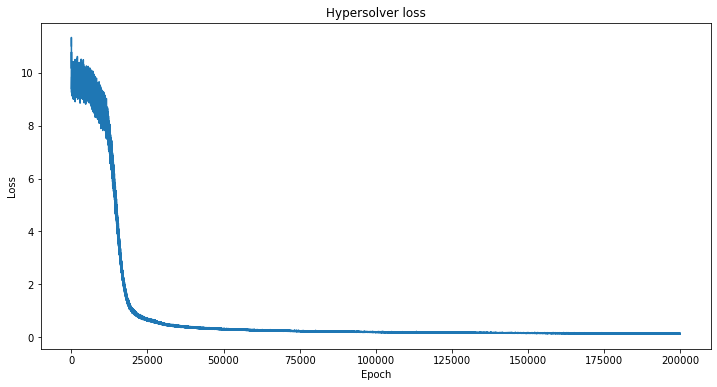

In [74]:
import numpy as np

dummmy = np.linspace(0,EPOCHS,EPOCHS)
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.plot( np.asarray(losses))
ax.set_title('Hypersolver loss')

In [75]:
torch.save(hs_snake, 'saved_models/hs_snake.pt')

## ReLU

In [76]:
class ReLUHyperSolver(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=32):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)

        # Initialize activations
        self.a1 = nn.ReLU()
        self.a2 = nn.ReLU()

    
    def forward(self, x):
        x = self.a1(self.fc1(x))
        x = self.a2(self.fc2(x))
        x = self.fc3(x)
        return x

hs_relu = ReLUHyperSolver(5, 2, hidden_dim=64)

pytorch_total_params = sum(p.numel() for p in hs_relu.parameters())
print(pytorch_total_params)

4674


In [77]:
opt = torch.optim.Adam(hs_relu.parameters(), lr=lr)

losses = []

bs = 1000
count = 0

with trange(0, EPOCHS, desc="Epochs") as epochs:
    for epoch in epochs:
        opt.zero_grad()
        
        x = torch.Tensor(bs, 2).uniform_(x_min_train, x_max_train)
        
        # Choose random indices",
        index = torch.randint(u_grid.shape[0], (bs,))
        u_rand = u_grid[index]

        # compute again residual for hypersolver training
        loss = compute_residual(system, t, Δt, x[:, None, :], u_rand[:, None, :], hs_relu, model='relu').mean()

        # optimization step
        loss.backward()
        opt.step()
        
        losses.append(loss.detach().cpu())
        # print(f"e:{epoch}, loss:%.3f" % loss, end="\r")
        epochs.set_postfix(loss=(loss.detach().cpu().item()))

Epochs: 100%|██████████| 200000/200000 [25:19<00:00, 131.61it/s, loss=0.0862]


Text(0.5, 1.0, 'Hypersolver loss')

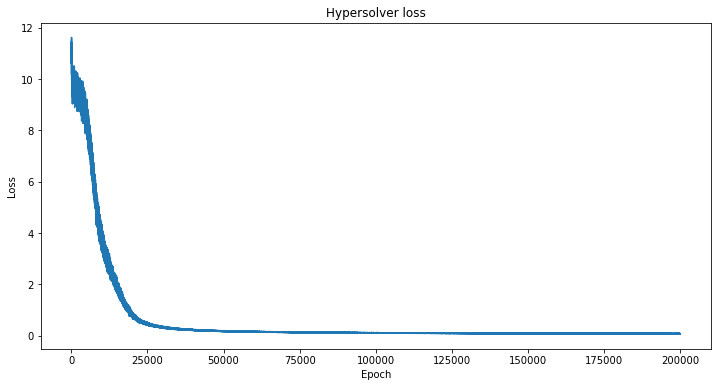

In [78]:
import numpy as np

dummmy = np.linspace(0,EPOCHS,EPOCHS)
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.plot( np.asarray(losses))
ax.set_title('Hypersolver loss')

In [79]:
torch.save(hs_relu, 'saved_models/hs_relu.pt')

## Tanh

In [80]:
class TanhHyperSolver(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=32):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)

        # Initialize activations
        self.a1 = nn.Tanh()
        self.a2 = nn.Tanh()

    
    def forward(self, x):
        x = self.a1(self.fc1(x))
        x = self.a2(self.fc2(x))
        x = self.fc3(x)
        return x

hs_tanh = TanhHyperSolver(5, 2, hidden_dim=64)

pytorch_total_params = sum(p.numel() for p in hs_tanh.parameters())
print(pytorch_total_params)

4674


In [81]:
opt = torch.optim.Adam(hs_tanh.parameters(), lr=lr)

losses = []

bs = 1000
count = 0

with trange(0, EPOCHS, desc="Epochs") as epochs:
    for epoch in epochs:
        opt.zero_grad()
        
        x = torch.Tensor(bs, 2).uniform_(x_min_train, x_max_train)
        
        # Choose random indices",
        index = torch.randint(u_grid.shape[0], (bs,))
        u_rand = u_grid[index]

        # compute again residual for hypersolver training
        loss = compute_residual(system, t, Δt, x[:, None, :], u_rand[:, None, :], hs_tanh, model='tanh').mean()

        # optimization step
        loss.backward()
        opt.step()
        
        losses.append(loss.detach().cpu())
        # print(f"e:{epoch}, loss:%.3f" % loss, end="\r")
        epochs.set_postfix(loss=(loss.detach().cpu().item()))

Epochs: 100%|██████████| 200000/200000 [25:13<00:00, 132.13it/s, loss=0.026]


Text(0.5, 1.0, 'Hypersolver loss')

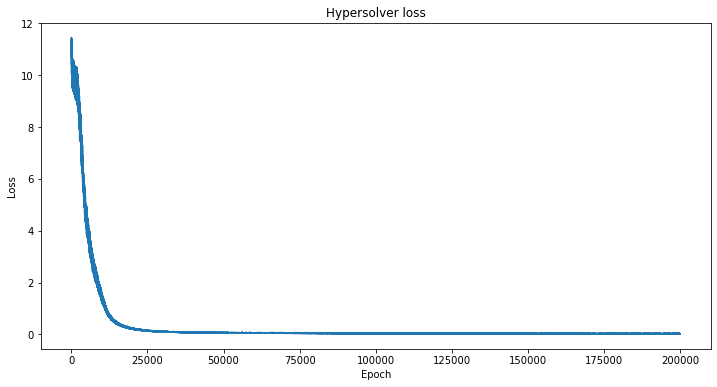

In [82]:
import numpy as np

dummmy = np.linspace(0,EPOCHS,EPOCHS)
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.plot( np.asarray(losses))
ax.set_title('Hypersolver loss')

In [83]:
torch.save(hs_tanh, 'saved_models/hs_tanh.pt')